### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
import sys, os
sys.path.append(os.path.abspath(".."))  
from dataset import PACSDataset, VLCSDataset, OfficeHomeDataset
from vit_grqo import ViTGRQO, grqo_loss_from_gradients
from encoder_decoder_vit import VisualDecoder, MultiheadAttn, DecoderAttn
from Visual_query_heads import QueryLosses, GRQO
from transformers import ViTModel, AutoFeatureExtractor

### CONFIG 

In [2]:
import os
from datasets import load_dataset
from PIL import Image

# Your constants
OFFICEHOME_ROOT = r"D:\Haseeb\Datasets\OfficeHomeDataset_10072016"
OFFICEHOME_DOMAINS = ["Art", "Clipart", "Product", "Real World"]
NUM_CLASSES = 65   # Office-Home has 65 categories
BATCH_SIZE = 32
NUM_EPOCHS = 5
LR = 1e-4
TOPK = 24
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset = load_dataset("flwrlabs/pacs", split="train")

# os.makedirs(DATA_ROOT, exist_ok=True)
# for domain in DOMAINS:
#     for cls in CLASSES:
#         os.makedirs(f"{DATA_ROOT}/{domain}/{cls}", exist_ok=True)

# for i, example in enumerate(dataset):
#     domain = example["domain"]  
#     label_idx = example["label"]  
#     label = CLASSES[label_idx]

#     if domain not in DOMAINS:
#         raise ValueError(f"Unexpected domain: {domain}. Expected one of {DOMAINS}")
#     if label not in CLASSES:
#         raise ValueError(f"Unexpected label: {label}. Expected one of {CLASSES}")
    
#     image = example["image"]
#     image.save(f"{DATA_ROOT}/{domain}/{label}/image_{i}.jpg")


### Data

In [3]:
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

officehome_data = OfficeHomeDataset(OFFICEHOME_ROOT, TRANSFORM, batch_size=32)

ALL_DOMAINS = ["Art", "Clipart", "Product", "Real_World"]


### Model 

In [4]:
# ViT-Tiny Backbone from Hugging Face ---
vit_encoder = ViTModel.from_pretrained("WinKawaks/vit-tiny-patch16-224")
HIDDEN_DIM = vit_encoder.config.hidden_size  # 192 for ViT-Tiny

# GRQO Hyperparameters ---
NUM_HEADS = 6
DROPOUT = 0.1
NUM_LAYERS = 3
DDROPOUT = 0.1
NUM_TOKENS = 32
TEMPERATURE = 0.1
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3
LAMBDA_GRQO = 1.0
TEACHER_EMA = 0.99
NUM_CLASSES = 65

# GRQO Decoder ---
grqo_model = GRQO(
    Hidden_dim=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    num_tokens=NUM_TOKENS,
    ddropout=DDROPOUT,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    temperature=TEMPERATURE,
    alpha=ALPHA,
    beta=BETA,
    tau=TAU,
    lambda_grqo=LAMBDA_GRQO,
    teacher_ema=TEACHER_EMA,
    reward_proxy="taylor"
)

# Full ViTGRQO Model ---
class ViTGRQO(nn.Module):
    def __init__(self, vit_encoder, grqo_model):
        super().__init__()
        self.vit = vit_encoder
        self.grqo = grqo_model

    def forward(self, x, labels=None):
        # Get patch embeddings from HF ViT (exclude CLS token)
        outputs = self.vit(pixel_values=x, output_hidden_states=True)
        patch_tokens = outputs.last_hidden_state[:, 1:, :]  # [B, N, D] skip CLS token
        return self.grqo(patch_tokens, labels)

# Initialize model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Model initialized on {device}")
print(f"Hidden dim: {HIDDEN_DIM}, Num tokens: {NUM_TOKENS}")

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized on cuda
Hidden dim: 192, Num tokens: 32


### training

In [5]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_cls_loss = 0.0
    total_grqo_loss = 0.0
    correct = 0
    total_samples = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images, labels)
        
        # Extract losses
        loss = output['loss']
        cls_loss = output['cls_loss']
        grqo_loss = output['grqo_loss']
        preds = output['preds']
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * images.size(0)
        total_cls_loss += cls_loss.item() * images.size(0)
        total_grqo_loss += grqo_loss.item() * images.size(0)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, '
                  f'Cls: {cls_loss.item():.4f}, GRQO: {grqo_loss.item():.4f}')
    
    avg_loss = total_loss / total_samples
    avg_cls_loss = total_cls_loss / total_samples
    avg_grqo_loss = total_grqo_loss / total_samples
    accuracy = correct / total_samples
    
    return avg_loss, avg_cls_loss, avg_grqo_loss, accuracy

### evaluation

In [6]:
def validate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # GRQO needs gradients even during validation
        with torch.set_grad_enabled(True):
            output = model(images, labels)
            preds = output['preds']
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

### finetuning 

In [7]:
# OfficeHome LODO Training & Evaluation
ALL_DOMAINS = ["Art", "Clipart", "Product", "Real World"]
lodo_results = {}

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out domain '{LEAVE_OUT}' ===")
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Create data loaders
    train_datasets = [officehome_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = officehome_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # Reset model for this split
    model = ViTGRQO(vit_encoder, grqo_model).to(DEVICE)

    FREEZE_VIT = False
    if FREEZE_VIT:
        for param in model.vit.parameters():
            param.requires_grad = False
    
    # Optimizer
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(trainable_params, lr=LR, weight_decay=0.01)

    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_cls, train_grqo, train_acc = train_epoch(model, train_loader, optimizer, DEVICE)
        
        # Validate  
        val_acc = validate(model, val_loader, DEVICE)
        
        print(f"Train - Loss: {train_loss:.4f}, Cls: {train_cls:.4f}, "
              f"GRQO: {train_grqo:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    lodo_results[VAL_DOMAIN] = best_val_acc
    print(f"Best Val Acc for {VAL_DOMAIN}: {best_val_acc:.4f}")

# Results Summary
print("\n" + "="*50)
print("OfficeHome LODO RESULTS SUMMARY")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average':15}: {avg_lodo:.4f}")
print("="*50)


=== LODO: Leaving out domain 'Art' ===

Epoch 1/5
Batch 0, Loss: 4.3362, Cls: 4.2763, GRQO: 0.0599
Batch 50, Loss: 3.7342, Cls: 3.7255, GRQO: 0.0087
Batch 100, Loss: 2.6913, Cls: 2.6856, GRQO: 0.0056
Batch 150, Loss: 1.9798, Cls: 1.9750, GRQO: 0.0049
Batch 200, Loss: 1.6863, Cls: 1.6815, GRQO: 0.0048
Batch 250, Loss: 1.5235, Cls: 1.5191, GRQO: 0.0044
Batch 300, Loss: 1.0551, Cls: 1.0510, GRQO: 0.0041
Train - Loss: 2.2990, Cls: 2.2921, GRQO: 0.0069, Acc: 0.5157
Val Acc (Art): 0.5844

Epoch 2/5
Batch 0, Loss: 0.6356, Cls: 0.6315, GRQO: 0.0042
Batch 50, Loss: 0.9417, Cls: 0.9379, GRQO: 0.0038
Batch 100, Loss: 0.6216, Cls: 0.6179, GRQO: 0.0037
Batch 150, Loss: 0.5659, Cls: 0.5621, GRQO: 0.0037
Batch 200, Loss: 0.8627, Cls: 0.8590, GRQO: 0.0037
Batch 250, Loss: 0.8864, Cls: 0.8827, GRQO: 0.0037
Batch 300, Loss: 1.0842, Cls: 1.0809, GRQO: 0.0033
Train - Loss: 0.7733, Cls: 0.7696, GRQO: 0.0036, Acc: 0.8345
Val Acc (Art): 0.6152

Epoch 3/5
Batch 0, Loss: 0.5282, Cls: 0.5254, GRQO: 0.0028
Batc

### Baseline

In [8]:
print("\n=== Leave-One-Domain-Out (LODO) Training & Validation on Office-Home ===")

# Office-Home domains
ALL_DOMAINS = ["Art", "Clipart", "Product", "Real World"]

lodo_results = {}  # store per-domain results

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out {LEAVE_OUT.upper()} for validation ===")
    
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # ---- Train loader (concat all train domains) ----
    train_datasets = [officehome_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    # ---- Validation loader (only leave-out domain) ----
    val_loader = officehome_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # ---- Model (reset for each LODO run) ----
    model = ViTForImageClassification.from_pretrained(
        "WinKawaks/vit-tiny-patch16-224",
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (Leave out {VAL_DOMAIN})")

        # ---- Training ----
        model.train()
        running_loss, running_corrects, running_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            running_corrects += (preds == labels).sum().item()
            running_samples += labels.size(0)

        train_loss = running_loss / running_samples
        train_acc = running_corrects / running_samples

        # ---- Validation on held-out domain ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = outputs.logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total if total > 0 else 0.0

        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val Acc ({VAL_DOMAIN}): {val_acc:.4f}")

        # Track best validation accuracy
        best_val_acc = max(best_val_acc, val_acc)

    # Save best result for this LODO run
    lodo_results[VAL_DOMAIN] = best_val_acc

# ---------------- Results Summary ----------------
print("\n" + "="*50)
print("LODO RESULTS SUMMARY (Office-Home)")
print("="*50)
for domain, acc in lodo_results.items():
    print(f"{domain:15}: {acc:.4f}")

avg_lodo = sum(lodo_results.values()) / len(lodo_results)
print(f"{'Average LODO':15}: {avg_lodo:.4f}")
print("="*50)


=== Leave-One-Domain-Out (LODO) Training & Validation on Office-Home ===

=== LODO: Leaving out ART for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([65, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out Art)
Train - Loss: 1.4301, Acc: 0.6570
Val Acc (Art): 0.5926

Epoch 2/5 (Leave out Art)
Train - Loss: 0.3645, Acc: 0.9070
Val Acc (Art): 0.6029

Epoch 3/5 (Leave out Art)
Train - Loss: 0.1485, Acc: 0.9663
Val Acc (Art): 0.6008

Epoch 4/5 (Leave out Art)
Train - Loss: 0.0827, Acc: 0.9816
Val Acc (Art): 0.5885

Epoch 5/5 (Leave out Art)
Train - Loss: 0.0667, Acc: 0.9835
Val Acc (Art): 0.5823

=== LODO: Leaving out CLIPART for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([65, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out Clipart)
Train - Loss: 1.4129, Acc: 0.6669
Val Acc (Clipart): 0.4822

Epoch 2/5 (Leave out Clipart)
Train - Loss: 0.3172, Acc: 0.9226
Val Acc (Clipart): 0.5086

Epoch 3/5 (Leave out Clipart)
Train - Loss: 0.1031, Acc: 0.9817
Val Acc (Clipart): 0.5178

Epoch 4/5 (Leave out Clipart)
Train - Loss: 0.0385, Acc: 0.9939
Val Acc (Clipart): 0.4937

Epoch 5/5 (Leave out Clipart)
Train - Loss: 0.0229, Acc: 0.9957
Val Acc (Clipart): 0.5143

=== LODO: Leaving out PRODUCT for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([65, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out Product)
Train - Loss: 1.7062, Acc: 0.5953
Val Acc (Product): 0.7241

Epoch 2/5 (Leave out Product)
Train - Loss: 0.4636, Acc: 0.8816
Val Acc (Product): 0.7320

Epoch 3/5 (Leave out Product)
Train - Loss: 0.1641, Acc: 0.9650
Val Acc (Product): 0.7545

Epoch 4/5 (Leave out Product)
Train - Loss: 0.0807, Acc: 0.9824
Val Acc (Product): 0.7545

Epoch 5/5 (Leave out Product)
Train - Loss: 0.0536, Acc: 0.9868
Val Acc (Product): 0.7691

=== LODO: Leaving out REAL WORLD for validation ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([65]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([65, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5 (Leave out Real World)
Train - Loss: 1.6730, Acc: 0.6016
Val Acc (Real World): 0.7351

Epoch 2/5 (Leave out Real World)
Train - Loss: 0.4260, Acc: 0.8966
Val Acc (Real World): 0.7615

Epoch 3/5 (Leave out Real World)
Train - Loss: 0.1525, Acc: 0.9681
Val Acc (Real World): 0.7683

Epoch 4/5 (Leave out Real World)
Train - Loss: 0.0872, Acc: 0.9804
Val Acc (Real World): 0.7638

Epoch 5/5 (Leave out Real World)
Train - Loss: 0.0572, Acc: 0.9863
Val Acc (Real World): 0.7752

LODO RESULTS SUMMARY (Office-Home)
Art            : 0.6029
Clipart        : 0.5178
Product        : 0.7691
Real World     : 0.7752
Average LODO   : 0.6663


### Plot

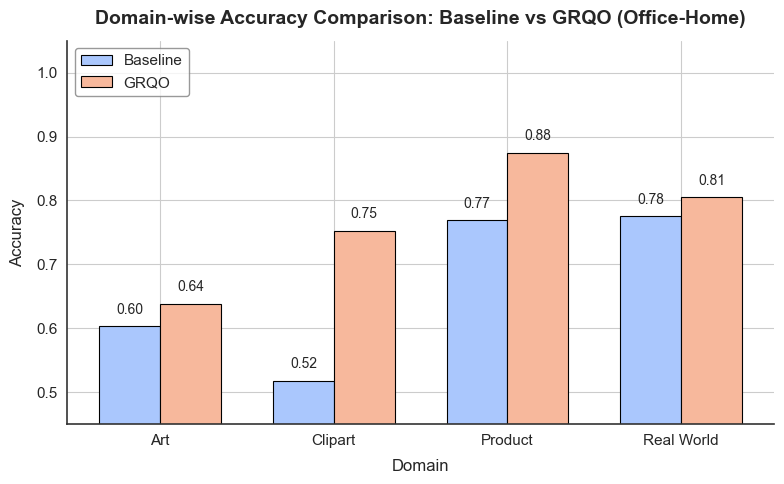

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Clean Seaborn aesthetic
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.figsize": (8, 5),
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2
})

# Data
domains = ["Art", "Clipart", "Product", "Real World"]
baseline = [0.6029, 0.5178, 0.7691, 0.7752]
grqo = [0.6379, 0.7526, 0.8750, 0.8050]

x = np.arange(len(domains))
width = 0.35

# Refined color palette (balanced greens & teals)
colors = sns.color_palette("coolwarm", 2)

fig, ax = plt.subplots()

# Bars with subtle outlines
bars1 = ax.bar(x - width/2, baseline, width, label='Baseline',
               color=colors[0], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, grqo, width, label='GRQO',
               color=colors[1], edgecolor='black', linewidth=0.8)

# Axis labels and title
ax.set_ylabel('Accuracy', labelpad=8)
ax.set_xlabel('Domain', labelpad=8)
ax.set_title('Domain-wise Accuracy Comparison: Baseline vs GRQO (Office-Home)', 
             pad=12, fontweight='semibold')
ax.set_xticks(x)
ax.set_xticklabels(domains)
ax.set_ylim(0.45, 1.05)

# Add bar labels with precision
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.015,
                f"{height:.2f}", ha='center', va='bottom', fontsize=10, fontweight='medium')

annotate_bars(bars1)
annotate_bars(bars2)

# Legend and final polish
ax.legend(frameon=True, fancybox=True, facecolor='white',
          edgecolor='gray', loc='upper left')
sns.despine(left=False, bottom=False)

plt.tight_layout()
plt.show()